# BitBIRCH

This notebook acts as a tutorial for the usage of the new refinement methods available in [BitBIRCH](https://pubs.rsc.org/en/content/articlelanding/2025/dd/d5dd00030k).

Please reach out to one of the following with any questions or concerns. 

Ramon Alain Miranda Quintana: <ramirandaq@gmail.com>, <quintana@chem.ufl.edu>

Kate Huddleston: <kdavis2@chem.ufl.edu>

Kenneth Lopez Perez: <klopezperez@chem.ufl.edu>
                            

Please install the bitbirch editable package using the following commands in your terminal (individually):
```
git clone https://github.com/mqcomplab/bitbirch.git
cd bitbirch
pip install -e .
```

In [1]:
## Imports 
import numpy as np
from rdkit import Chem
import bitbirch.bitbirch as bb
import bitbirch.plotting_utils as plotting_utils
import pandas as pd

## Setting up our data

First let's take our SMILES strings and compute our molecular fingerprints. With BitBIRCH, it is **REQUIRED** that the molecular representations are binary fingerprints of dtype int64. 

Below we are reading the .smi file and outputting some np.array of SMILES strings. 

In [23]:
with open('../../data/chembl_33_np.smi', 'r') as f:
    smiles = np.array([line.strip() for line in f])
print("Number of smiles: ", smiles.shape[0])

Number of smiles:  64086


We then use [RDKIT](https://github.com/rdkit/rdkit) to generate our binary fingerprints.

In [77]:
mols = [Chem.MolFromSmiles(S) for S in smiles]
fps = np.array([Chem.RDKFingerprint(mol) for mol in mols])  

Check that the number of fingerprints and smiles match

In [9]:
n_mols = len(fps)
n_smiles = len(smiles)

print("Number of mols and smiles is the same: ", n_mols == n_smiles)

Number of mols and smiles is the same:  True


Now let's check the quality of the generated fingerprints. As stated about we need them to be binary of dtype int64. 

In [4]:
print(f'Bits are binary: {np.all(np.isin(fps, [0, 1]))}')
print(f'Data type is int64: {fps.dtype == np.int64 or fps.dtype == np.float64}')

Bits are binary: True
Data type is int64: True


Now we are going to set a threshold and branching factor for our clustering

In [5]:
branching_factor = 50
threshold = 0.65

According to our observations in the refinement paper, we determined that the best way was to do initially diameter birch. We are going to fit now the fingerprints.

In [6]:
bb.set_merge('diameter')
brc = bb.BitBirch(threshold=threshold, branching_factor=branching_factor)
brc.fit(fps)

Saved cluster metrics for diameter to data/diameter_cluster_metrics.csv


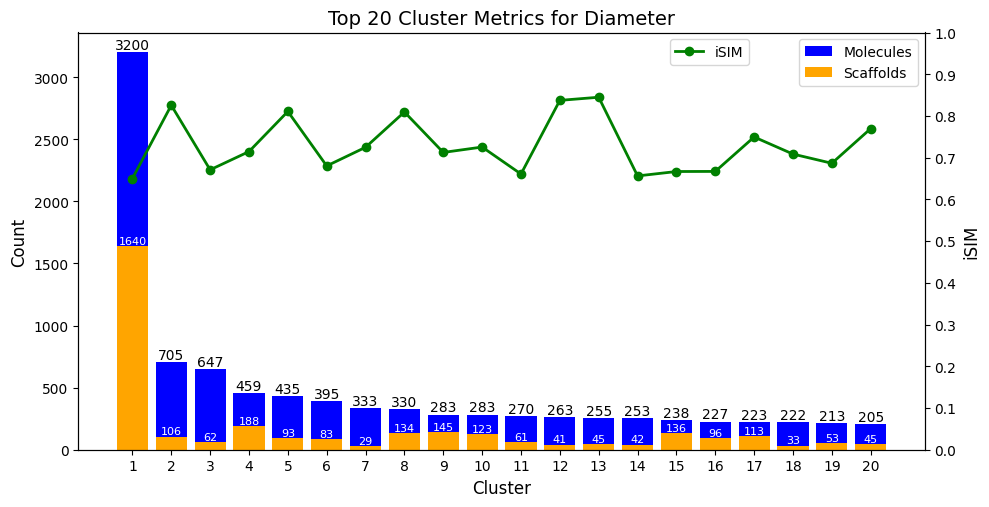

In [7]:
plotting_utils.save_metrics_to_csv(brc, fps, smiles, method='diameter')
plotting_utils.init_plot('diameter')

### Refining our results

You can notice above that there's a big cluster with a numerous number of scaffolds. If your data, does not present a large cluster with high number of scaffolds, your clustering is done, no need to refine.
For this we are going to create a new tree passing at first the well-defined clusters and then the molecules in the biggest/messy cluster.


In [7]:
# Prepare the data from the first tree to refit
rest, big = brc.prepare_data_BFs(fps)

# Delete the initial tree to save memory
#del brc

# Create a new tree, this time with the data from the first tree and using tolerance merging and a higher threshold
bb.set_merge('tolerance', 0.00)
threshold = 0.70
brc_refined = bb.BitBirch(threshold=threshold, branching_factor=branching_factor)

# Fit the new tree, notice that for this we are using fit_BFs, since we took the BitFeatures from the first tree
brc_refined.fit_BFs(rest)
brc_refined.fit_BFs(big)

Saved cluster metrics for refined to data/refined_cluster_metrics.csv


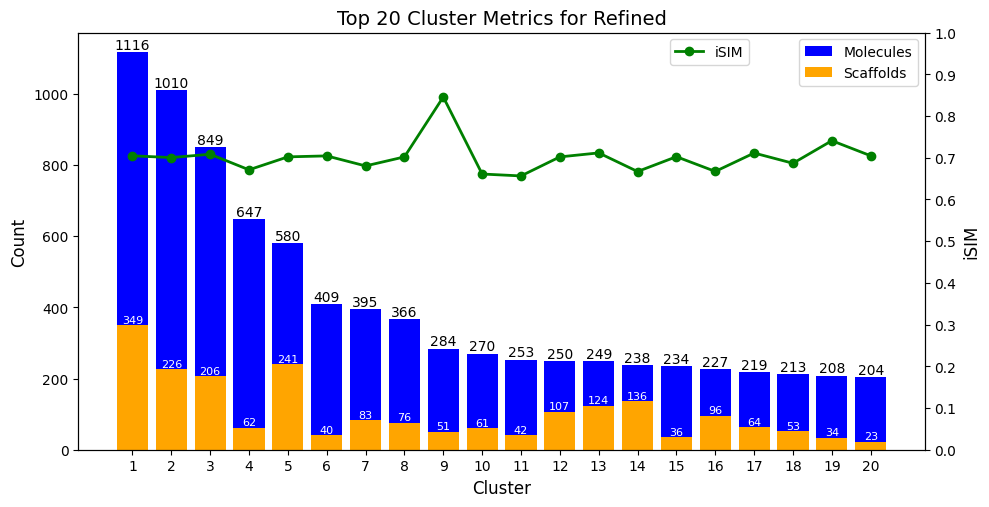

In [10]:
plotting_utils.save_metrics_to_csv(brc_refined, fps, smiles, method='refined')
plotting_utils.init_plot('refined')

In case you want to visually inspect the cluster, with the following function you can generate images with the structres in each cluster. You just need not input the bitbirch object, the smiles, and the cluster number you want to plot. The function will generate multiple images with 30 molecules each, since it is not convenient to have all in one.

In [27]:
plotting_utils.mol_visualization(smiles, brc_refined, cluster=1243)

Number of molecules: 8


If a spatial visualization is wanted, we can create a tSNE plot

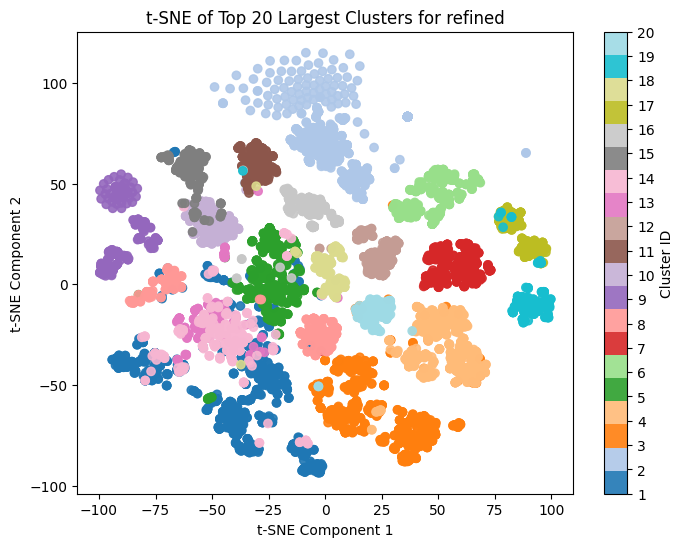

In [31]:
plotting_utils.tsne_plot(brc_refined, fps, "refined", title="refined")

Let's check the number of generated clusters and number of clusters above 10 molecules

In [30]:
mol_ids = brc_refined.get_cluster_mol_ids()
print("Number of clusters: ", len(mol_ids))

# Get the clusters with more than 10 molecules
clusters = [cluster for cluster in mol_ids if len(cluster) > 10]
print("Number of clusters with more than 10 molecules: ", len(clusters))

Number of clusters:  14653
Number of clusters with more than 10 molecules:  979


If we are content with our clustering we can do the final assignments for our data.

In [24]:
assignments = brc_refined.get_assignments(n_mols=n_mols)

# Save assignments to our smiles
df = pd.DataFrame({'smiles': smiles, 'assignments': assignments})
df.to_csv('smiles_assignments.csv', index=False)